# INN Model with colon MC data

In [1]:
%%capture

from google.colab import drive
drive.mount('/content/drive')

!pip install FrEIA
%cd /content/drive/MyDrive/Trial1/hvs_hsi_pytorch_colab
!pip install -e .

%cd /content/drive/MyDrive/Trial1/HVS_INN_MC_Project_colab

## Import

In [2]:
# %matplotlib notebook
# %load_ext jupyternotify

# Dataset config choice
import src.config as c

from src.dataset import *
from src.inn_model import *

import shutil
import torch
import copy
import pandas as pd
import numpy as np

from sklearn.cluster import MeanShift
from sklearn.neighbors import KernelDensity

# Set seed
_ = torch.manual_seed(0)

## Load data

In [3]:
# Read reformatted dataset
path = ["data/mc/colon_train_15.7.15.4_power_led_300_norm_l1.csv",
        "data/mc/colon_train_15.7.15.4_power_led_300.csv", 
        "data/mc/generic_train_15.7.15.4_power_led_300_norm_l1.csv",
        "data/mc/generic_train_15.7.15.4_power_led_300.csv"]
i_path = 3
data_df = pd.read_csv(path[i_path])
# data_df = data_df.sample(n=10000)

for i in data_df.columns:
    if 'a_mie' in i:
        data_df[i] = (data_df[i] - 500) / (5000 - 500)

n_train = int(len(data_df) * (1 - c.valid_percent))
train_df = data_df[:n_train]
valid_df = data_df[n_train:]

In [4]:
data_df

,layer0_sao2,layer0.1_vhb,layer0.2_a_mie,layer0.3_b_mie,layer0.4_a_ray,layer0.5_g,layer0.6_n,layer0.7_d,layer1_sao2,layer1.1_vhb,...,516.9379,524.29926,536.7569,544.5972,555.9696,562.3306,574.3978,581.5989,588.1238,598.2659
0,0.694279,0.121864,0.999129,2.779289,0.0,0.819493,1.513056,0.000317,0.411836,0.294346,...,0.067622,0.059313,0.043912,0.042345,0.042662,0.042958,0.045593,0.051154,0.072850,0.115771
1,0.634955,0.058130,0.736768,1.278168,0.0,0.837641,1.520842,0.001757,0.964131,0.129041,...,0.106531,0.096375,0.076505,0.075040,0.076915,0.078328,0.083566,0.093066,0.123526,0.181508
2,0.265839,0.210962,0.048290,2.408457,0.0,0.860235,1.340427,0.001066,0.740341,0.257844,...,0.005045,0.004375,0.003295,0.003064,0.002861,0.002880,0.003330,0.003723,0.004910,0.007568
3,0.318810,0.187162,0.779092,1.641721,0.0,0.876391,1.527974,0.001328,0.128209,0.084886,...,0.032876,0.028863,0.021879,0.020527,0.019645,0.020013,0.023204,0.026350,0.035157,0.053699
4,0.595107,0.145280,0.541321,2.093285,0.0,0.831180,1.452853,0.001071,0.225921,0.116364,...,0.036327,0.031512,0.023030,0.022168,0.022214,0.022580,0.025128,0.028724,0.041806,0.068951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.094528,0.016991,0.338305,1.823465,0.0,0.805168,1.506876,0.001106,0.139417,0.291386,...,0.148771,0.139053,0.119997,0.112797,0.106216,0.106677,0.116330,0.123566,0.136067,0.160685
499996,0.055097,0.144204,0.330603,0.888885,0.0,0.903651,1.389760,0.001276,0.444238,0.230640,...,0.024859,0.021971,0.017271,0.015997,0.014855,0.015271,0.018852,0.021486,0.026886,0.039216
499997,0.169536,0.200183,0.388185,2.974964,0.0,0.936695,1.391461,0.000829,0.290029,0.170349,...,0.017470,0.014911,0.010899,0.009856,0.008845,0.008822,0.010213,0.011324,0.014580,0.021764
499998,0.657893,0.254214,0.937831,2.768408,0.0,0.816540,1.464050,0.001228,0.885169,0.171977,...,0.031960,0.027409,0.019475,0.018696,0.018677,0.018879,0.020772,0.023681,0.035638,0.061029


## Train process

In [5]:
# %%notify
# Data loader
train_dataset = McDataset(train_df, c)
train_loader = data_utils.DataLoader(train_dataset, batch_size=c.batch_size, shuffle=True, drop_last=True)
valid_dataset = McDataset(valid_df, c)
valid_loader = data_utils.DataLoader(valid_dataset, batch_size=min(len(valid_df), c.valid_batch_size), shuffle=True, drop_last=True)

# Set up dimensionality
c.ndim_y = train_dataset.get_y_dim()
c.ndim_x = train_dataset.get_x_dim()
c.ndim_tot = max(c.ndim_y, c.ndim_x) + c.ndim_z

# Model
model = inn_model(c)

# Optimizer
trainable_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_parameters, lr=c.lr, betas=c.betas, eps=c.eps, weight_decay=c.l2_reg)
c.optimizer = optimizer

# Initialization of trainable parameters
for param in trainable_parameters:
    param.data = c.init_scale * torch.randn_like(param)
model = model.to(c.device)

info_nn = "Layer: " + str(c.n_layers) + " Neurons: " + str(c.n_neurons)
info_dim = 'x: ' + str(c.ndim_x) + ", y: " + str(c.ndim_y) + ", z: " + str(c.ndim_z) + ", tot: " + str(c.ndim_tot)
print(info_nn)
print(info_dim)
print("Training - Using device: " + c.device)

Layer: 10 Neurons: 128
x: 3, y: 16, z: 20, tot: 36
Training - Using device: cuda


INFO:root:MAE Sao2 0 - 0.065514


Epoch 108 :
MAE Sao2 0 - 0.065514


<Figure size 432x288 with 0 Axes>

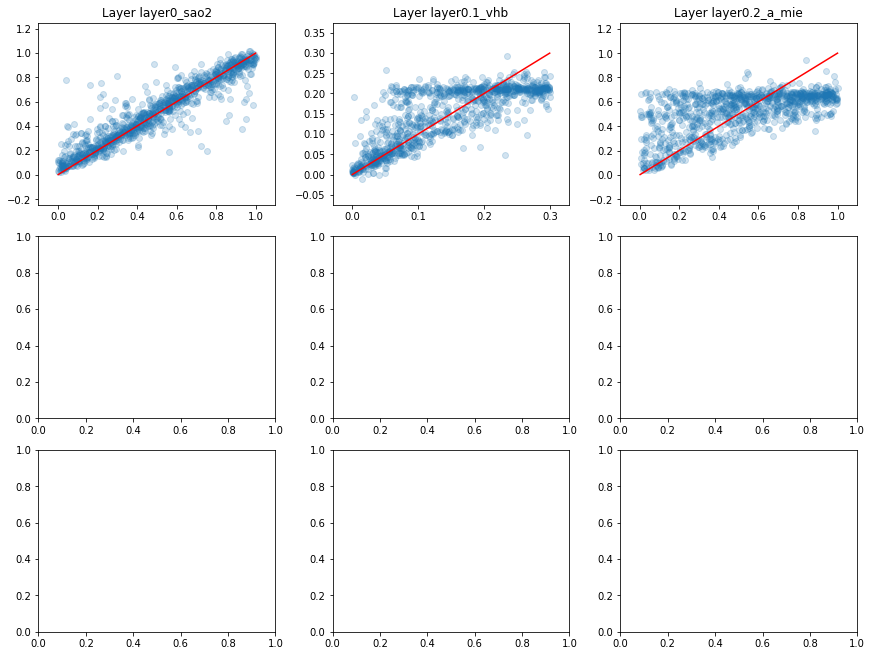

In [ ]:
train(model, train_loader, valid_loader, c)

In [ ]:
c.logger.info(path[i_path])
c.logger.info(c.parameters)
c.logger.info(info_dim)

In [ ]:
# img_path = "data/imgs/frames/exported4034.png"
# white_path = "data/imgs/exported_white_2022-03-10-10-45-04.png"

# img = hsi_utils.load_sample(img_path)
# white = hsi_utils.load_sample(white_path)

# hsi_data = HSImage(array=img, wavelengths=None, camera="imec 4x4-VIS-15.7.15.4")
# hsi_data.calibrate(white=white)
# hsi_data.demosaic()
# hsi_data.correct()
# hsi_origin = copy.deepcopy(hsi_data)
# hsi_data.array = utils.normalise_L1(hsi_data.array)

# data = hsi_data.array
# shape = data.shape
# data = data.reshape(shape[0], shape[1] * shape[2]).swapaxes(0, 1)

# step = 2 ** 13
# batch = list(np.arange(data.shape[0], step=step))
# batch.append(data.shape[0])

# output = torch.tensor([])
# for i in tqdm(range(len(batch) - 1), ascii=True, ncols=100):
#     y = data[batch[i]:batch[i + 1]].to(c.device)
#     z = c.z_noise_scale * torch.randn(y.shape[0], c.ndim_z).to(c.device)
#     y = torch.cat((torch.zeros(y.shape[0], c.ndim_tot - c.ndim_y - c.ndim_z).to(c.device), y), dim=1)
#     y = torch.cat((z, y), dim=1).to(c.device)
#     pred_x = model(y, rev=True)[0][:, c.target].detach().cpu().clone()
#     output = torch.cat((output, pred_x))

# output = output.reshape(shape[1], shape[2])[:, :, None]

In [ ]:
# show_hvs_combo(hsi_origin, mask=True)

In [ ]:
# show_inn_combo_norm(hsi_origin, output, mask=True)

In [ ]:
# img_path = "data/finger_data/session_001/P010001_V03_iHSI_T01_2022-07-28-16-16-54/raw/frame_000010_raw.png"
# white_path = "data/finger_data/session_001/exported_white_2022-07-15-20-29-45.png"

# img = hsi_utils.load_frame(img_path)
# white = hsi_utils.load_sample(white_path)

# hsi_data = HSImage(array=img, wavelengths=None, camera="imec 4x4-VIS-15.7.15.4")
# hsi_data.reconstruct(white=white, dark=None, rho=15, method="flatfield")
# hsi_origin = copy.deepcopy(hsi_data)
# hsi_data.array = utils.normalise_L1(hsi_data.array)

# # Data reformat
# data = hsi_data.array
# shape = data.shape
# data = data.reshape(shape[0], shape[1] * shape[2]).swapaxes(0, 1)

# step = 2 ** 14
# batch = list(np.arange(data.shape[0], step=step))
# batch.append(data.shape[0])

# output = torch.tensor([])
# for i in tqdm(range(len(batch) - 1), ascii=True, ncols=100):
#     y = data[batch[i]:batch[i + 1]].to(c.device)
#     z = c.z_noise_scale * torch.randn(y.shape[0], c.ndim_z).to(c.device)
#     y = torch.cat((torch.zeros(y.shape[0], c.ndim_tot - c.ndim_y - c.ndim_z).to(c.device), y), dim=1)
#     y = torch.cat((z, y), dim=1).to(c.device)
#     pred_x = model(y, rev=True)[0][:, c.target].detach().cpu().clone()
#     output = torch.cat((output, pred_x))

# output = output.reshape(shape[1], shape[2])[:, :, None]

In [ ]:
# show_hvs_combo(hsi_origin, mask=False)

In [ ]:
# show_inn_combo_norm(hsi_origin, output, mask=False)

## Compute posterior

In [ ]:
# rows, cols = 3, 3

# # Load validation data loader
# valid_dataset = McDataset(valid_df, c)
# valid_loader = data_utils.DataLoader(valid_dataset, batch_size=rows * cols, shuffle=True, drop_last=True)

# z = torch.randn(500, c.ndim_z)

# plt.figure()
# fig, axs = plt.subplots(rows, cols, constrained_layout=True, figsize=(9, 6))

# for x, y in valid_loader:
#     with torch.no_grad():
#         map_x = np.zeros(x.shape[0])
#         for i, j in enumerate(y):
#             print("%d / %d" % (i, len(y)))
#             clear_output(wait=True)

#             pred_x = compute_posterior(model, j, z, c)[:, 0][:, None]
#             density = KernelDensity(bandwidth=0.01, kernel='gaussian').fit(pred_x)
#             centers = MeanShift(bandwidth=0.02, n_jobs=-1, min_bin_freq=100).fit(pred_x).cluster_centers_
#             plot_x = np.linspace(0, 1, 1000)[:, None]
#             log_dens = density.score_samples(plot_x)
#             for k in centers:
#                 axs[i // rows][i % rows].axvline(x=k)
#             axs[i // rows][i % rows].plot(pred_x[:, 0], -0.005 - 0.01 * np.random.random(pred_x.shape[0]), "+k")
#             axs[i // rows][i % rows].plot(plot_x[:, 0], np.exp(log_dens), color="navy", lw=2, linestyle="-")
#     break

## Compute target layer's MAP estimation $n_{sample}=500$

In [ ]:
# %%time

# # Load validation data loader
# valid_dataset = McDataset(valid_df, c)
# valid_loader = data_utils.DataLoader(valid_dataset, batch_size=100, shuffle=True, drop_last=True)

# n_sample = 10
# z = torch.randn(n_sample, c.ndim_z)
# mae_map = None

# plt.figure()
# fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(9, 6))

# for x, y in valid_loader:
#     with torch.no_grad():
#         map_x = np.zeros(x.shape[0])
#         for i, j in enumerate(tqdm(y, ascii=True, ncols=100)):
#             pred_x = compute_posterior(model, j, z, c)[:, c.target][:, None]
#             density = KernelDensity(bandwidth=0.01, kernel='gaussian').fit(pred_x)
#             centers = MeanShift(bandwidth=0.02, n_jobs=-1, min_bin_freq=100).fit(pred_x).cluster_centers_
#             estimates = density.score_samples(centers)
#             map_x[i] = centers[np.argmax(estimates)]

#         axs.scatter(x[:, c.target].numpy(), map_x, alpha=0.5)
#         axs.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), c='red')
#         axs.set_ylim([-0.8, 1.8])
#         axs.set_title('MAP Layer 2')

#         mae_map = metrics.mean_absolute_error(x[:, c.target].numpy(), map_x)
#         info = "MAE StO2 Layer 2 - MAP sample %d - %f" % (n_sample, mae_map)
#         print(info)
#         c.logger.info(info)
#     break

### Comment this cell after run

In [ ]:
name_model = 'model_pig_3'

# name_model = 'model_' + 'generic' + '_' + str(mae_map)[2:6]
shutil.copyfile('src/config.py', 'models/' + name_model + '_config.py')
torch.save(model.state_dict(), 'models/' + name_model)
shutil.copyfile('runs/current.log', 'models/' + name_model + '.log')